## Repaso - Bayesiana

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import theano as tt
import pymc3
import arviz as az
import warnings

warnings.filterwarnings('ignore')

#tt.config.on_unused_input = 'ignore'
#tt.config.compute_test_value = 'ignore'

librerias = {
    'numpy': [np, '1.19.2'],
    'seaborn': [sns, '0.11.0'],
    'pandas': [pd, '1.1.3'],
    'theano': [tt, '1.0.11'],
    'pymc3': [pymc3, '3.10.0'],
    'arviz': [az, '0.11.0']
}

for k,v in librerias.items():
    print(  k.ljust(12, ' '), 
            ('OK' if v[0].__version__ == v[1] else 'NO OK').ljust(10, ' '), 
            v[0].__version__)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


numpy        NO OK      1.20.2
seaborn      NO OK      0.11.1
pandas       NO OK      1.2.4
theano       OK         1.0.11
pymc3        OK         3.10.0
arviz        OK         0.11.0


#### Puntos de corte entre tendencias

<AxesSubplot:>

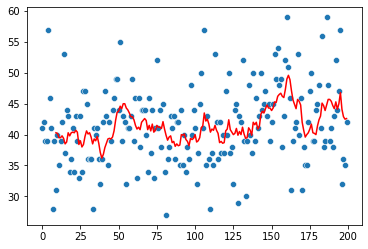

In [2]:
import pandas as pd

data_1 = [41, 42, 39, 39, 57, 46, 41, 28, 39, 31, 40, 35, 39, 42, 53, 37, 44,
       43, 34, 36, 41, 34, 43, 39, 33, 43, 34, 47, 47, 45, 36, 36, 36, 28,
       41, 40, 41, 36, 32, 36, 42, 47, 43, 35, 42, 39, 44, 46, 49, 49, 44,
       55, 39, 43, 42, 32, 41, 41, 43, 49, 39, 46, 33, 46, 38, 44, 44, 44,
       40, 34, 46, 37, 44, 33, 41, 52, 41, 44, 38, 45, 34, 27, 36, 38, 43,
       41, 43, 36, 42, 42, 35, 44, 35, 40, 34, 38, 36, 48, 40, 44, 41, 32,
       37, 45, 50, 41, 57, 35, 43, 36, 28, 37, 35, 53, 42, 36, 42, 37, 40,
       37, 47, 40, 50, 37, 38, 32, 44, 45, 29, 43, 42, 52, 39, 30, 39, 48,
       40, 37, 50, 39, 46, 41, 43, 50, 44, 45, 47, 43, 45, 39, 42, 45, 53,
       49, 54, 48, 49, 38, 43, 52, 59, 51, 46, 31, 39, 41, 42, 53, 40, 46,
       31, 38, 35, 35, 42, 47, 50, 39, 39, 44, 45, 48, 41, 56, 38, 39, 59,
       48, 39, 41, 38, 43, 52, 44, 47, 57, 32, 36, 35, 42]
s = pd.Series(data_1)
sns.scatterplot(data=data_1)

sns.lineplot(data=s.rolling(10).mean(), color='red')

Como primer punto, vamos a partir de los datos entre las observaciones 0 y 99 e intentar obtener la distribución subyacente.

Para ello utilizaremos una librería que se llama PyMC3 (Python MonteCarlo) que nos permite automatizar miles de pruebas de validez de una hipótesis.

La librería es un poco críptica y quizás se explica mejor a través de un ejemplo:

<AxesSubplot:ylabel='Count'>

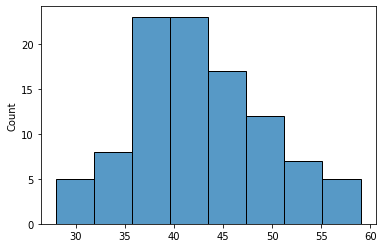

In [3]:
sns.histplot(data_1[-100:])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


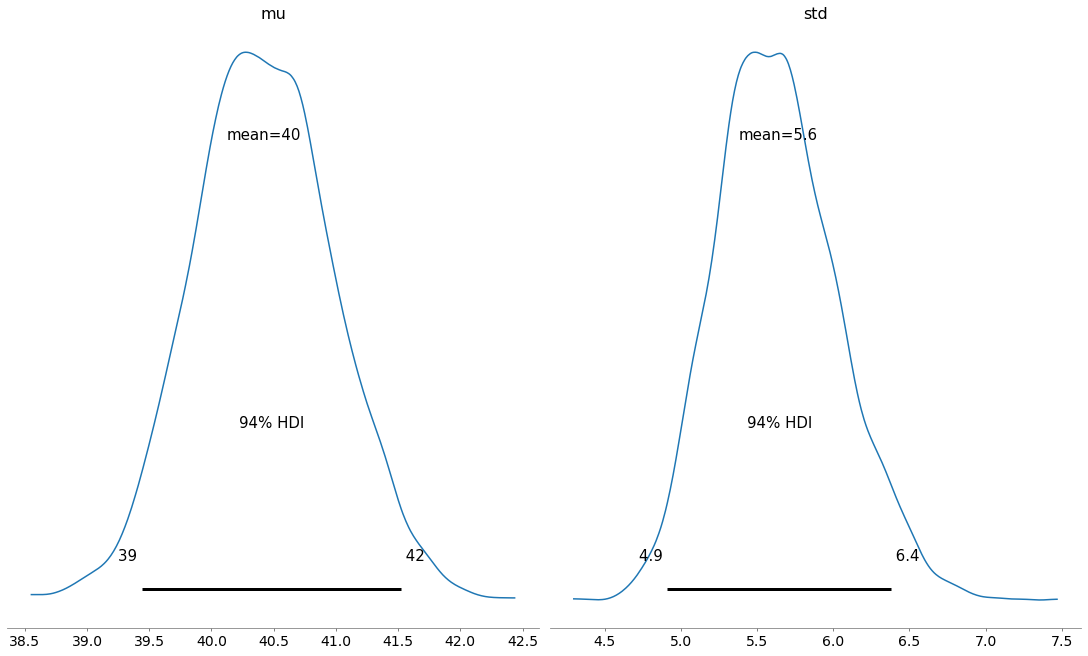

In [4]:
import pymc3 as pm
import arviz as az
import numpy as np

datos = data_1[:100]

with pm.Model() as model:
    # Suponiendo que los datos siguen una distribucion normal
    mu = pm.Exponential('mu',lam = 1/np.mean(datos))
    std = pm.Exponential('std', lam = 1 / np.mean(datos))
    
    # 4. La definición de estos parámetros servirá para que PyMC3 genere miles de posibles muestras normales
    # con media obtenida de mu y desviación típica obtenida de std y busque para qué conjunto de parámetros
    # nos acercamos más a la muestra que hemos generado. Se escoge la distribución exponencial para determinar los params
    # porque esta distribución tiene todos los valores hasta infinito
    
    obs = pm.Normal('obs',mu=mu,sigma=std,observed=datos)
    trace =pm.sample()
    az.plot_posterior(trace,figsize=(15,9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


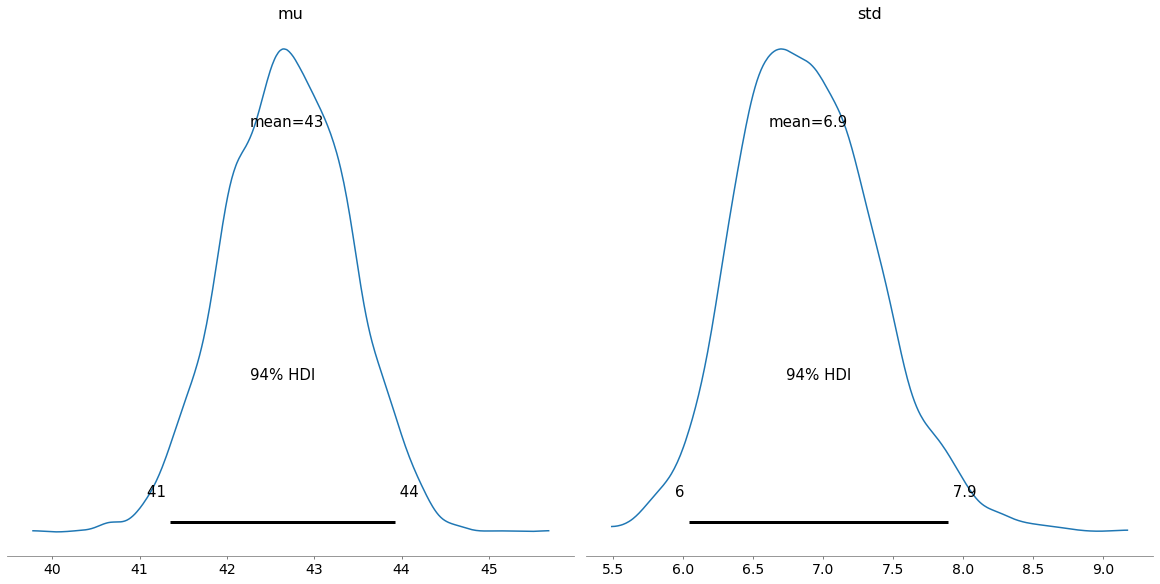

In [5]:
# Y hacemos lo propio para la segunda mitad de los datos
datos = data_1[-100:]

# Iniciamos un modelo de PyMC3, el modelo va añadiendo todos los **pasos** a un proceso y luego llamamos 
# a ese proceso mediante pm.sample para obtener el resultado
with pm.Model() as model:
    # Vamos a suponer que los datos del principio de data 1 pertenecen a una distribución normal
    
    # 2. Definimos el parámetro A como unos datos extraídos de una distribución exponencial
    mu = pm.Exponential('mu', lam = 1 / np.mean(datos))
    # 3. Definimos el parámetro B igual que el A
    std = pm.Exponential('std', lam = 1 / np.mean(datos))
    # 4. La definición de estos parámetros servirá para que PyMC3 genere miles de posibles muestras normales
    # con media obtenida de p_A y desviación típica obtenida de p_B y busque para qué conjunto de parámetros
    # nos acercamos más a la muestra que hemos generado
    
    # 1. Le decimos que hay unas observaciones que creemos que siguen una distribución normal
    # y que tienen como parámetro de media valores obtenidos de un conjunto posible llamado p_A
    # y desviación típica obtenida de un conjunto posible llamado p_B
    obs = pm.Normal('obs',  mu=mu, sigma=std, observed=datos)
    
    # 5. Le decimos que trabaje
    trace = pm.sample()

    # 6. le decimos que muestre los resultados
    az.plot_posterior(trace, figsize=(16,8))


Evidentemente existe un cambio de tendencia (ver media). ¿Pero cuando se produce?

In [6]:
model.obs

obs ~ Normal

In [7]:
model.mu

mu ~ Exponential

In [8]:
model.std

std ~ Exponential

In [11]:
observaciones = len(data_1)

with pm.Model() as model:
    # Vamos a decirle a PyMC3 que creemos que existen dos distribuciones en los datos
    # como no sabemos nada de esas distribuciones utilizamos como base una distribución
    # exponencial
    
    # Hacer esto es un poco complejo ya que requiere empezar por le final.
    
    # Si nos fijamos en obervation veremos que ahí le decimos que creemos que tenemos dos conjuntos de observaciones
    # obesrvation y observation_2, empezamos por el 1.
    
    # Valor inicial de las distribuciones
    alpha = 1.0/np.mean(data_1)
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    # Llamamos tau al parámetro que separa los valores, al igual que antes,
    # no hacemos ninguna suposición sobre qué valor puede tomar tau,
    # por lo tanto incializamos la distibución entre 0 y el número de observaciones menos 1.
    
    tau = pm.DiscreteUniform("tau", lower=0, upper = observaciones - 1)
    
    idx = np.arange(observaciones) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2) # En algun punto de las observaciones hay un corte (tau)
    # que separa a los dos lados, lambda1 y lambda2
    #lambda_ será la media y std de la distribución final
    observation = pm.Normal("obs", lambda_, observed=data_1)
    
    # El método metropolis recoge todos los datos que hemos ido generando hasa ahora
    # y aplica un algoritmo MCMC (Markov-Chain Monte Carlo) para inferir los parámetros
    # de la distribución subyacente en los datos
    step = pm.Metropolis()
    
    # Finalmente, le pedimos a PyMC3 que realice el proceso de inferencia.
    # Todos los datos que fuimos añadiendo al modelo están listos para utilizarse
    # y solo queda esperar (15 minutos)
    trace = pm.sample(25000, tune=5000,step=step, return_inferencedata=True)
    
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 25_000 draw iterations (20_000 + 100_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [14]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

<AxesSubplot:>

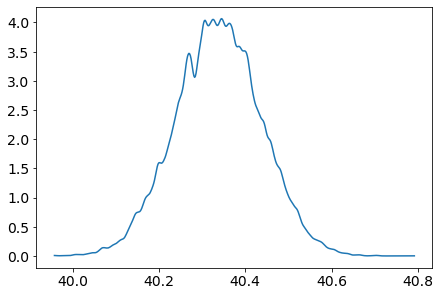

In [13]:
az.plot_dist(trace['posterior']['lambda_1'])

<AxesSubplot:>

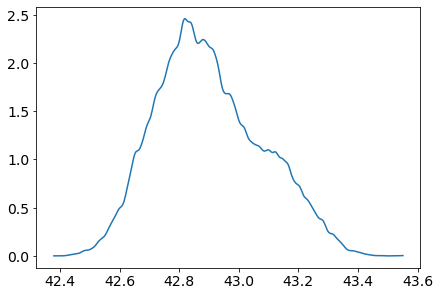

In [16]:
az.plot_dist(trace['posterior']['lambda_2'])


<AxesSubplot:>

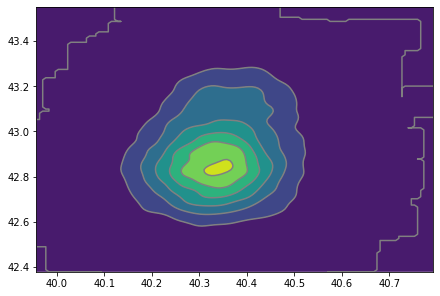

In [17]:
az.plot_dist(values=trace['posterior']['lambda_1'], values2=trace['posterior']['lambda_2'])

<AxesSubplot:>

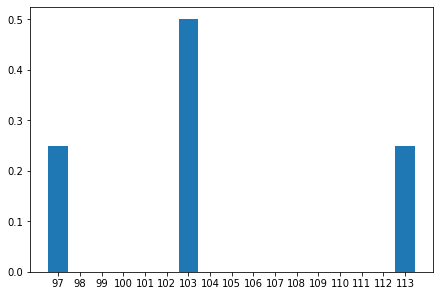

In [18]:
az.plot_dist(trace['posterior']['tau'])

In [21]:
trace['posterior']['lambda_2'].mean()

<xarray.DataArray 'lambda_2' ()>
array(42.90142971)

In [22]:
trace['posterior']['tau'].mean()

<xarray.DataArray 'tau' ()>
array(104.00008)

<AxesSubplot:>

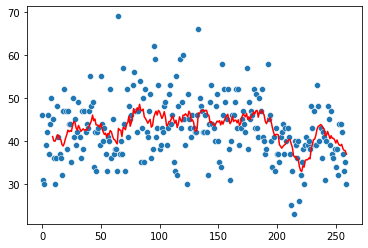

In [37]:
s = pd.Series(data_2)
sns.scatterplot(data=data_2)

sns.lineplot(data=s.rolling(10).mean(), color='red')

<AxesSubplot:ylabel='Count'>

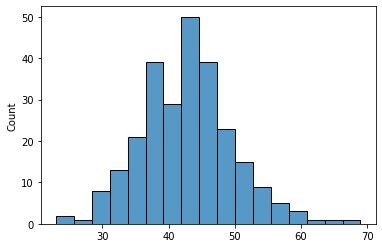

In [35]:
sns.histplot(data_2)

In [23]:
data_2 = [46, 31, 30, 39, 42, 46, 37, 44, 50, 45, 36, 30, 36, 48, 41, 37, 36,
       32, 47, 52, 47, 38, 47, 44, 44, 35, 50, 41, 45, 39, 42, 49, 41, 36,
       47, 38, 47, 42, 44, 43, 47, 55, 48, 49, 34, 42, 33, 42, 43, 39, 55,
       44, 40, 43, 37, 33, 41, 40, 52, 36, 45, 37, 38, 38, 33, 69, 37, 40,
       37, 57, 44, 33, 52, 41, 48, 45, 46, 53, 56, 47, 47, 42, 47, 54, 35,
       43, 50, 35, 52, 42, 41, 47, 51, 36, 38, 62, 59, 41, 43, 53, 38, 39,
       43, 42, 48, 49, 39, 43, 51, 53, 44, 46, 35, 33, 55, 32, 48, 59, 43,
       49, 60, 45, 39, 30, 51, 45, 43, 41, 46, 43, 42, 42, 46, 66, 50, 48,
       47, 42, 42, 46, 42, 32, 44, 49, 53, 44, 43, 40, 48, 51, 40, 35, 34,
       58, 46, 52, 49, 45, 52, 38, 31, 40, 46, 46, 49, 52, 43, 52, 39, 43,
       45, 47, 44, 42, 57, 38, 49, 45, 47, 46, 52, 43, 51, 43, 41, 50, 47,
       52, 41, 40, 37, 38, 58, 45, 46, 40, 34, 41, 33, 43, 37, 37, 35, 41,
       42, 44, 37, 43, 40, 43, 41, 37, 25, 33, 23, 40, 39, 36, 40, 26, 32,
       35, 38, 30, 39, 41, 39, 40, 38, 48, 43, 47, 39, 39, 53, 48, 40, 43,
       36, 42, 41, 31, 40, 48, 45, 39, 47, 37, 36, 38, 34, 38, 32, 44, 44,
       42, 37, 33, 35, 30]

import pymc3 as pm
import numpy as np

# Vamos a intentar encontrar el punto de corte suponiendo que los modelos responden a una distribución exponencial.

observaciones = len(data_2)

# Inicializamos un modelo de PyMC3
with pm.Model() as model:
    
    # Vamos a decirle a PyMC3 que creemos que existen dos distribuciones en los datos
    # como no sabemos nada de esas distribuciones utilizamos como base una distribución
    # exponencial.
    
    # PyMC3 exige que le demos un valor inicial a las distribuciones, como tampoco sabemos 
    # qué valor darle a esas exponenciales, utilizamos 1 / media como valor inicial.
    
    # Valor inicial de las distribuciones
    alpha = 1.0/np.mean(data_2)
    # Le decimos que va a haber dos distribuciones
    # estas distribuciones se almacenan en parámetros "lambda"
    # en inferencia bayesiana es habitual llamar "lambda" a los conocidos como 
    # hiperparámetros
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    lambda_3 = pm.Exponential("lambda_3", alpha)
    
    # Llamamos tau al parámetro que separa los valores, al igual que antes,
    # no hacemos ninguna suposición sobre qué valor puede tomar tau,
    # por lo tanto incializamos la distibución entre 0 y el número de observaciones menos 1.
    
    # Si disponemos de algo más de información, podemos acotar este rango de valores 
    # para agilizar el proceso
    tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper= int(observaciones/2) - 1)
    tau_2 = pm.DiscreteUniform("tau_2", lower=int(observaciones/2)-1, upper= observaciones - 1)
    
    # la función switch le dice a PyMc3 que existe un punto de corte y que lambda_1 y lambda_2
    # estarán a uno u otro lado del valor de corte
    # lambda_ es solo una variable "temporal" para almacenar estos valores
    idx_1 = np.arange(observaciones) # Index
    idx_2 = np.arange(observaciones) # Index
    
    lambda_ = pm.math.switch(tau_1 > idx_1, lambda_1, lambda_2)
    lambda_2 = pm.math.switch(tau_2 > idx_2, lambda_2, lambda_3)
    
    # Le decimos a PyMC que existirá una distribución de poisson 
    # estas son las observaciones, el P(B) del teorema de Bayes
    observation_1 = pm.Poisson("obs_1", lambda_, observed=data_2)
    observation_2 = pm.Poisson("obs_2", lambda_2, observed=data_2)

    # Por último le pedimos que inicie el proceso de análisis.
    
    # El método metropolis recoge todos los datos que hemos ido generando hasa ahora
    # y aplica un algoritmo MCMC (Markov-Chain Monte Carlo) para inferir los parámetros
    # de la distribución subyacente en los datos
    step = pm.Metropolis()
    
    # Finalmente, le pedimos a PyMC3 que realice el proceso de inferencia.
    # Todos los datos que fuimos añadiendo al modelo están listos para utilizarse
    # y solo queda esperar (15 minutos)
    trace = pm.sample(25000, tune=5000,step=step, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_2]
>Metropolis: [tau_1]
>Metropolis: [lambda_3]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 25_000 draw iterations (20_000 + 100_000 draws total) took 86 seconds.
The number of effective samples is smaller than 10% for some parameters.


<AxesSubplot:>

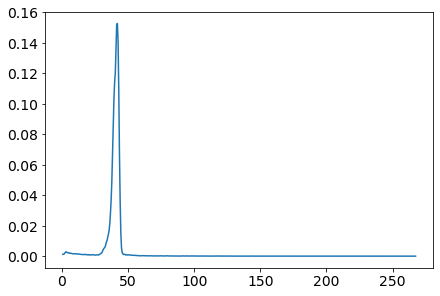

In [24]:
az.plot_dist(trace['posterior']['lambda_1'])

<AxesSubplot:>

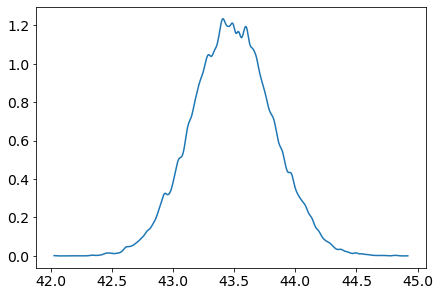

In [25]:
az.plot_dist(trace['posterior']['lambda_2'])


<AxesSubplot:>

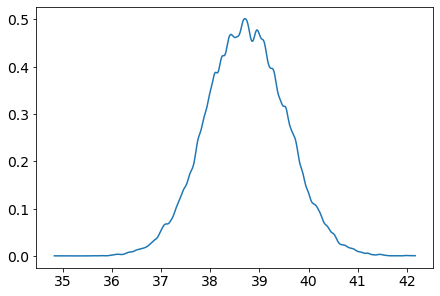

In [26]:
az.plot_dist(trace['posterior']['lambda_3'])

<AxesSubplot:>

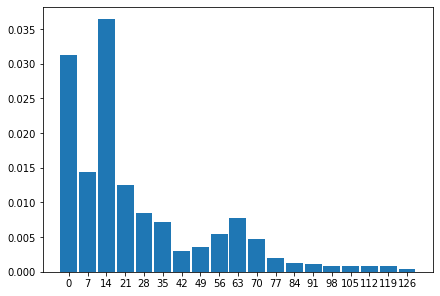

In [27]:
az.plot_dist(trace['posterior']['tau_1'])

In [28]:
trace['posterior']['tau_1'].mean()

<xarray.DataArray 'tau_1' ()>
array(27.98593)

In [29]:
trace['posterior']['tau_2'].mean()

<xarray.DataArray 'tau_2' ()>
array(196.32107)

<AxesSubplot:>

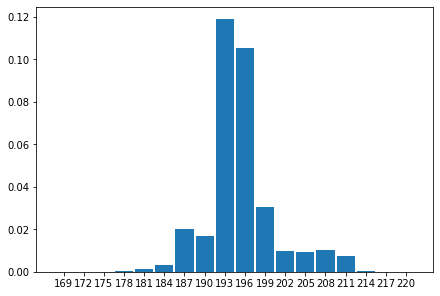

In [30]:
az.plot_dist(trace['posterior']['tau_2'])

In [40]:
for i in range(1,4):
    print(trace['posterior']['lambda_{}'.format(i)].mean())

<xarray.DataArray 'lambda_1' ()>
array(39.75277492)
<xarray.DataArray 'lambda_2' ()>
array(43.48312818)
<xarray.DataArray 'lambda_3' ()>
array(38.72922996)


<AxesSubplot:>

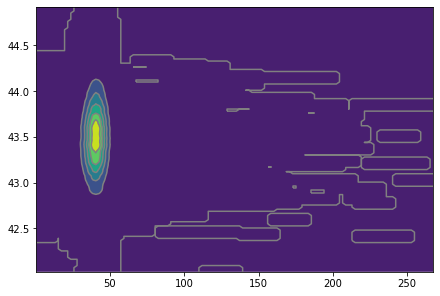

In [41]:
az.plot_dist(trace['posterior']['lambda_1'], trace['posterior']['lambda_2'])

In [51]:
trace['posterior']

<xarray.Dataset>
Dimensions:   (chain: 4, draw: 25000)
Coordinates:
  * chain     (chain) int32 0 1 2 3
  * draw      (draw) int32 0 1 2 3 4 5 6 ... 24994 24995 24996 24997 24998 24999
Data variables:
    tau_1     (chain, draw) int64 5 5 0 0 0 0 10 10 9 ... 8 38 60 60 62 62 62 62
    tau_2     (chain, draw) int64 197 197 197 194 196 ... 193 198 198 200 204
    lambda_1  (chain, draw) float64 40.14 40.14 47.82 53.7 ... 42.65 42.65 42.65
    lambda_2  (chain, draw) float64 43.36 43.36 43.36 ... 43.56 43.56 43.56
    lambda_3  (chain, draw) float64 38.71 38.71 39.14 39.14 ... 38.93 38.93 38.0
Attributes:
    created_at:                 2022-05-07T11:02:03.781242
    arviz_version:              0.11.0
    inference_library:          pymc3
    inference_library_version:  3.10.0
    sampling_time:              86.21057271957397
    tuning_steps:               5000

<AxesSubplot:>

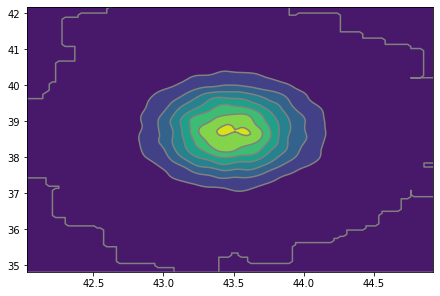

In [49]:
az.plot_dist(trace['posterior']['lambda_2'], trace['posterior']['lambda_3'])

array([[<AxesSubplot:title={'center':'tau_1'}>,
        <AxesSubplot:title={'center':'tau_2'}>,
        <AxesSubplot:title={'center':'lambda_1'}>],
       [<AxesSubplot:title={'center':'lambda_2'}>,
        <AxesSubplot:title={'center':'lambda_3'}>, <AxesSubplot:>]],
      dtype=object)

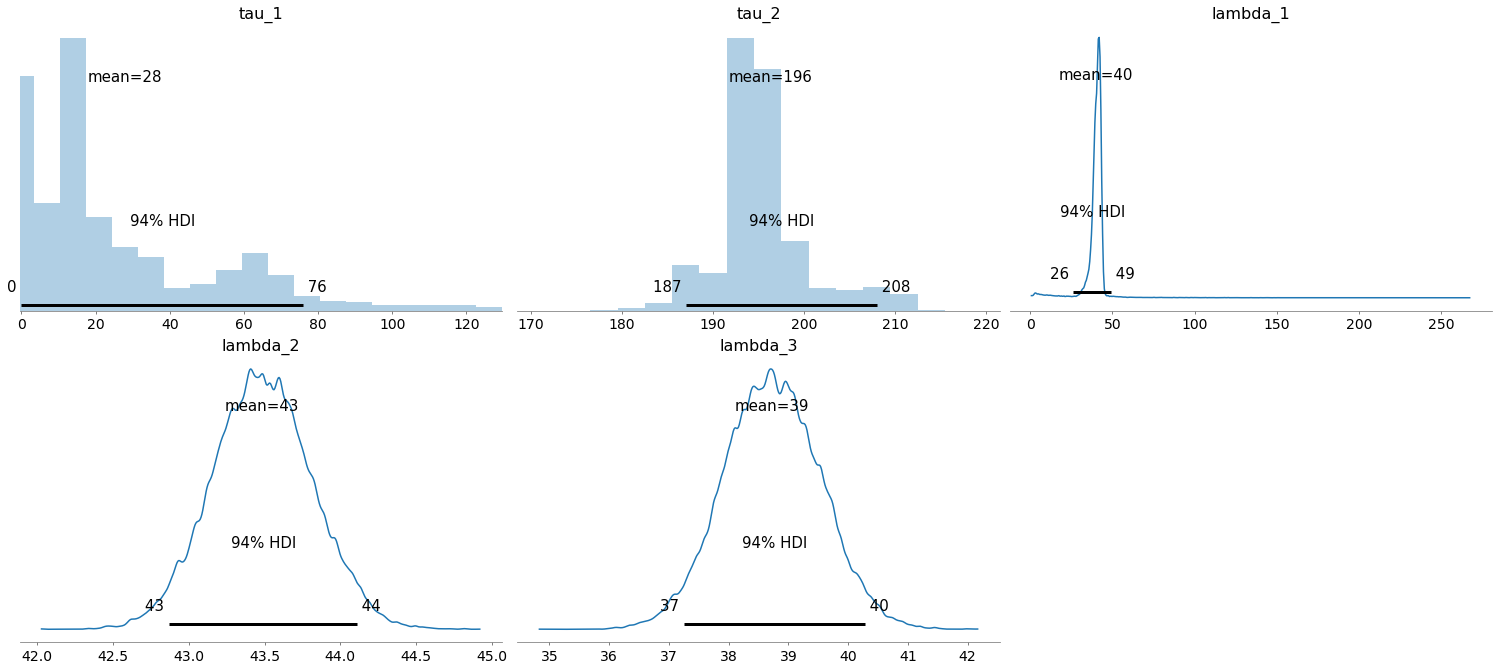

In [52]:
az.plot_posterior(trace)

[35 38 48 43 57 29 49 38 44 42 34 55 42 40 37 41 36 37 44 39 45 36 42 46
 27 42 39 44 37 49 47 45 39 37 39 45 39 44 38 61 35 49 37 38 39 38 46 46
 36 47 40 44 31 45 31 35 34 41 40 42 39 26 33 44 48 46 45 37 35 41 41 44
 34 37 37 48 32 46 38 39 43 34 32 43 38 50 40 53 40 39 38 42 52 46 44 36
 48 38 36 44 45 36 32 47 47 43 35 28 51 59 44 40 36 23 43 40 51 48 33 44
 39 32 48 53 42 41 42 43 43 40 42 54 43 42 37 37 40 50 40 40 46 43 54 52
 35 52 44 45 42 38 40 44 41 43 39 51 49 55 50 38 41 49 46 49 49 45 39 37
 52 48 47 43 55 47 51 57 51 43 44 34 49 43 53 42 36 44 52 43 37 35 51 55
 46 48 48 43 46 50 48 45]


<AxesSubplot:>

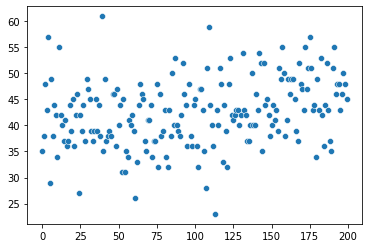

In [53]:
# Generación data_1
import numpy as np

np.random.seed(33)#99)

data_1a = np.random.poisson(40, 130)
data_1b = np.random.poisson(44, 70)

data_1 = np.concatenate([data_1a, data_1b])

print(data_1)

sns.scatterplot(data=data_1)

<AxesSubplot:>

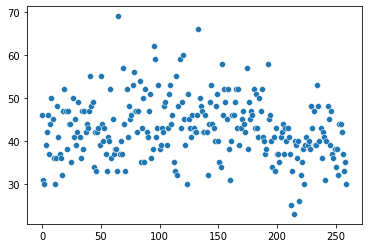

In [54]:
# Generación data_2
import numpy as np

np.random.seed(999)

data_2a = np.random.poisson(40, 65)
data_2b = np.random.poisson(46, 130)
data_2c = np.random.poisson(40, 65)

data_2 = np.concatenate([data_2a, data_2b, data_2c])

sns.scatterplot(data=data_2)

<AxesSubplot:>

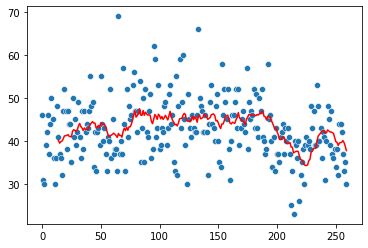

In [55]:
import pandas as pd
s = pd.Series(data_2)
sns.scatterplot(data=data_2)

sns.lineplot(data=s.rolling(15).mean(), color='red')

<AxesSubplot:ylabel='Count'>

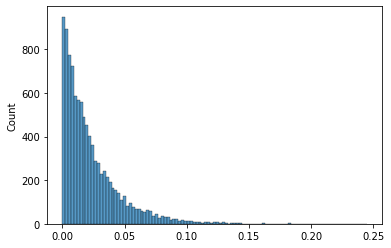

In [56]:
sns.histplot(data=np.random.exponential(scale=1/np.mean(data_2), size=10000 ))

In [57]:
data_2 = [46, 31, 30, 39, 42, 46, 37, 44, 50, 45, 36, 30, 36, 48, 41, 37, 36,
       32, 47, 52, 47, 38, 47, 44, 44, 35, 50, 41, 45, 39, 42, 49, 41, 36,
       47, 38, 47, 42, 44, 43, 47, 55, 48, 49, 34, 42, 33, 42, 43, 39, 55,
       44, 40, 43, 37, 33, 41, 40, 52, 36, 45, 37, 38, 38, 33, 69, 37, 40,
       37, 57, 44, 33, 52, 41, 48, 45, 46, 53, 56, 47, 47, 42, 47, 54, 35,
       43, 50, 35, 52, 42, 41, 47, 51, 36, 38, 62, 59, 41, 43, 53, 38, 39,
       43, 42, 48, 49, 39, 43, 51, 53, 44, 46, 35, 33, 55, 32, 48, 59, 43,
       49, 60, 45, 39, 30, 51, 45, 43, 41, 46, 43, 42, 42, 46, 66, 50, 48,
       47, 42, 42, 46, 42, 32, 44, 49, 53, 44, 43, 40, 48, 51, 40, 35, 34,
       58, 46, 52, 49, 45, 52, 38, 31, 40, 46, 46, 49, 52, 43, 52, 39, 43,
       45, 47, 44, 42, 57, 38, 49, 45, 47, 46, 52, 43, 51, 43, 41, 50, 47,
       52, 41, 40, 37, 38, 58, 45, 46, 40, 34, 41, 33, 43, 37, 37, 35, 41,
       42, 44, 37, 43, 40, 43, 41, 37, 25, 33, 23, 40, 39, 36, 40, 26, 32,
       35, 38, 30, 39, 41, 39, 40, 38, 48, 43, 47, 39, 39, 53, 48, 40, 43,
       36, 42, 41, 31, 40, 48, 45, 39, 47, 37, 36, 38, 34, 38, 32, 44, 44,
       42, 37, 33, 35, 30]

import pymc3 as pm
import numpy as np

# Vamos a intentar encontrar el punto de corte suponiendo que los modelos responden a una distribución exponencial.

observaciones = len(data_2)

# Inicializamos un modelo de PyMC3
with pm.Model() as model:
    
    # Vamos a decirle a PyMC3 que creemos que existen dos distribuciones en los datos
    # como no sabemos nada de esas distribuciones utilizamos como base una distribución
    # exponencial.
    
    # PyMC3 exige que le demos un valor inicial a las distribuciones, como tampoco sabemos 
    # qué valor darle a esas exponenciales, utilizamos 1 / media como valor inicial.
    
    # Valor inicial de las distribuciones
    alpha = 1.0/np.mean(data_2)
    
    # Le decimos que va a haber dos distribucionesb
    # estas distribuciones se almacenan en parámetros "lambda"
    # en inferencia bayesiana es habitual llamar "lambda" a los conocidos como 
    # hiperparámetros
    
    lambda_1 = pm.DiscreteUniform("lambda_1", np.min(data_2), np.max(data_2))
    lambda_2 = pm.DiscreteUniform("lambda_2", np.min(data_2), np.max(data_2))
    lambda_3 = pm.DiscreteUniform("lambda_3", np.min(data_2), np.max(data_2))
    
    # Llamamos tau al parámetro que separa los valores, al igual que antes,
    # no hacemos ninguna suposición sobre qué valor puede tomar tau,
    # por lo tanto incializamos la distibución entre 0 y el número de observaciones menos 1.
    
    # Si disponemos de algo más de información, podemos acotar este rango de valores 
    # para agilizar el proceso
    tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper= int(observaciones/2) - 1)
    tau_2 = pm.DiscreteUniform("tau_2", lower=int(observaciones/2)-1, upper= observaciones - 1)
    
    # la función switch le dice a PyMc3 que existe un punto de corte y que lambda_1 y lambda_2
    # estarán a uno u otro lado del valor de corte
    # lambda_ es solo una variable "temporal" para almacenar estos valores
    idx_1 = np.arange(observaciones) # Index
    idx_2 = np.arange(observaciones) # Index
    
    lambda_ = pm.math.switch(tau_1 > idx_1, lambda_1, lambda_2)
    lambda_2 = pm.math.switch(tau_2 > idx_2, lambda_2, lambda_3)
    
    # Le decimos a PyMC que existirá una distribución de poisson 
    # estas son las observaciones, el P(B) del teorema de Bayes
    observation_1 = pm.Poisson("obs_1", lambda_, observed=data_2)
    observation_2 = pm.Poisson("obs_2", lambda_2, observed=data_2)

    # Por último le pedimos que inicie el proceso de análisis.
    
    # El método metropolis recoge todos los datos que hemos ido generando hasa ahora
    # y aplica un algoritmo MCMC (Markov-Chain Monte Carlo) para inferir los parámetros
    # de la distribución subyacente en los datos
    step = pm.Metropolis()
    
    # Finalmente, le pedimos a PyMC3 que realice el proceso de inferencia.
    # Todos los datos que fuimos añadiendo al modelo están listos para utilizarse
    # y solo queda esperar (15 minutos)
    trace = pm.sample(25000, tune=5000,step=step, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_2]
>Metropolis: [tau_1]
>Metropolis: [lambda_3]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 25_000 draw iterations (20_000 + 100_000 draws total) took 80 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [59]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot:title={'center':'lambda_1'}>,
        <AxesSubplot:title={'center':'lambda_2'}>,
        <AxesSubplot:title={'center':'lambda_3'}>],
       [<AxesSubplot:title={'center':'tau_1'}>,
        <AxesSubplot:title={'center':'tau_2'}>, <AxesSubplot:>]],
      dtype=object)

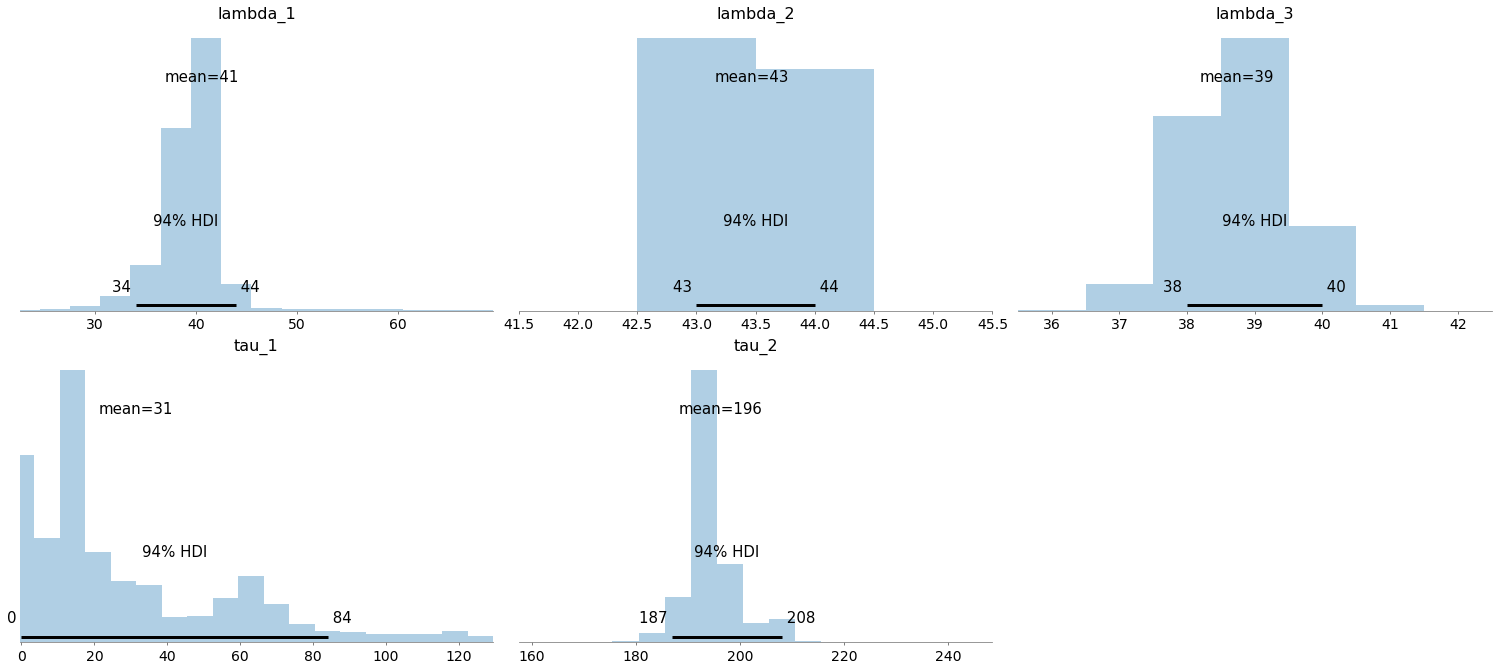

In [58]:
az.plot_posterior(trace)

In [60]:
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=1000, var_names=['lambda_1'])

## Aproximación a la inferencia Bayesiana

Cuál es el proceso que debemos seguir a la hora de enfrentar un problema de inferencia bayesiana?

El objetivo es conocer la probabilidad de que pase algo sabiendo que ocurrió otra cosa.
𝑃(𝐴|𝐵)=𝑃(𝐵|𝐴)∗𝑃(𝐴)/𝑃(𝐵)
 
Para ello lo primero que necesitamos es conocer nuestro P(A), esto es, nuestras observaciones.

Aunque el teorema de Bayes pida que P(A) sea un número, librerías como PyMC3 nos permiten pasar un conjunto de observaciones reales o incluso una distribución como origen.

<AxesSubplot:ylabel='Count'>

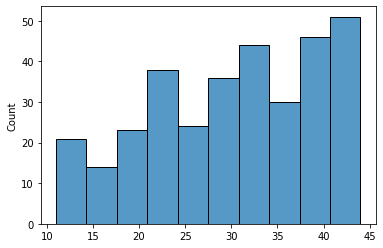

In [61]:
vta = [16, 39, 36, 30, 16, 29, 28, 21, 32, 20, 28, 41, 19, 21, 16, 37, 33,
       37, 41, 44, 25, 43, 16, 35, 41, 27, 11, 22, 38, 28, 21, 24, 30, 18,
       31, 20, 26, 42, 27, 44, 30, 39, 20, 11, 41, 33, 25, 43, 44, 20, 36,
       31, 30, 40, 38, 25, 30, 21, 26, 27, 36, 43, 18, 15, 38, 37, 41, 36,
       28, 35, 24, 20, 43, 32, 29, 16, 38, 37, 14, 29, 44, 31, 29, 41, 38,
       35, 25, 21, 44, 37, 38, 30, 24, 38, 34, 33, 42, 35, 27, 22, 34, 14,
       28, 41, 37, 16, 41, 42, 24, 11, 43, 36, 36, 31, 39, 36, 33, 28, 23,
       38, 25, 39, 20, 38, 13, 13, 39, 38, 16, 15, 40, 24, 31, 16, 36, 38,
       42, 42, 30, 38, 27, 35, 32, 29, 30, 39, 20, 21, 40, 38, 21, 20, 13,
       22, 40, 33, 37, 43, 23, 20, 12, 22, 36, 29, 42, 43, 33, 42, 44, 40,
       39, 31, 43, 44, 28, 26, 14, 34, 20, 14, 33, 15, 44, 28, 20, 18, 41,
       21, 39, 34, 28, 33, 21, 21, 23, 22, 31, 24, 40, 34, 29, 22, 40, 37,
       23, 38, 41, 42, 22, 15, 31, 27, 27, 44, 16, 34, 12, 33, 14, 32, 21,
       19, 44, 44, 14, 19, 29, 38, 24, 26, 25, 41, 41, 42, 23, 22, 34, 44,
       40, 32, 35, 19, 38, 29, 30, 28, 26, 44, 34, 29, 12, 43, 30, 36, 27,
       25, 22, 38, 21, 38, 24, 39, 35, 40, 38, 39, 21, 38, 14, 38, 33, 34,
       40, 14, 22, 31, 33, 12, 28, 44, 29, 44, 21, 18, 44, 20, 42, 12, 35,
       31, 34, 33, 35, 26, 43, 32, 26, 30, 18, 22, 34, 33, 28, 42, 26, 40,
       40, 18, 35, 16, 13, 44, 40, 33, 34, 37, 25, 18, 30, 41, 31, 30, 33,
       12, 40, 37, 38]

sns.histplot(data=vta)

<AxesSubplot:>

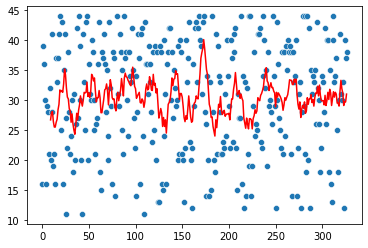

In [63]:
s = pd.Series(vta)
sns.scatterplot(data=vta)
sns.lineplot(data=s.rolling(10).mean(),color='red')

Vemos que la media de 10 periodos está bastante acotada entre 25 y 35 unidades pero las unidades en sí mismas varían desde 10 hasta 45

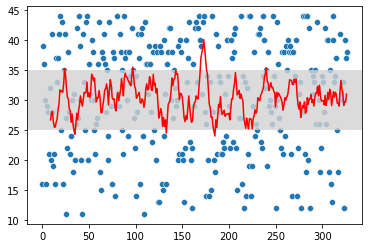

In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()

s = pd.Series(vta)

zona = patches.Rectangle((-50,25), 400,10, facecolor='lightgrey', alpha=.8)
sns.scatterplot(data=vta)
sns.lineplot(data=s.rolling(10).mean(), color='red')

ax.add_patch(zona)

Podemos crear un modelo que nos diga qué valores pueden estar detrás de esta distribución.

- Decidir la distribución que puede estar detrás.
- Plantear valores posibles
- Ejecutar el modelo

In [ ]:
with pm.Model() as model:
    p = pm.Uniform('p',lower = min(vta),upper=max(vta))
    obs = pm.Poisson('obs',p,observed=vta)
    step = pm.Metropolis()
    trace = pm.sample()